# Introduction

As the ever-changing landscape of the technology market in one of the most capitally-affluent nations begins to grow at rapid speeds beyond comprehension, the world watches and admires in how previous barriers to growth are almost immediately traversed with the ingenuity of emerging topics within machine learning, AI, and big data processes. However, among the many existing challenges within the market, the inability to accurately forecast and predict trends across multiple different latitudes have left high-level researchers and quantitative developers with numerous of unanswered questions and temporary solutions. Within this intersection of statistical modeling and machine learning, time series modeling allows users to model a time-correlated process and explore the impact of one of the most elusive, impactful predictors of any model, time itself. For the majority of the discipline's existence, stochastic models have dominated the methodology, harnessing Monte Carlo simulations and complex Markov chains to make accurate predictions to a somewhat fair degree. Primarily, these include ARIMA and SARIMA models, which model the influence of previous time points on current data. While robust to many troublesome patterns found within the average time series, their performative ability begins to decline with greater data complexity. Furthermore, parametric models, while accurate and reliable in their ideal conditions, always suffer from violated assumptions in modern-day applications. Among these violations is the lack of heteroskedasticity, which plagued models with inconsistent variance until Robert F. Engle's ARCH model $_{[1]}$ was born to combat its detrimental influence. 

As newly-explored innovations are being implemented to bridge the many gaps throughout predictive modeling, we would like to focus our attention on the 2017 research composition of Hristos Tyralis and Georgia Papacharalampous $_{[2]}$ which asserts the superior predictive ability of the random forest variable selection within the time series domain over their derived ACF and PACF counterparts. 

In order to advance our understanding of this topic, we will be expanding upon this study, utilizing the methodology of Tyralis and Papacharalampous to inspire our investigation into the effectiveness of random forest-engineered, multi-variate time series models in comparison to other contemporary methods. In addition to performing comparative measures of accuracy, we will be focusing our attention towards the unique attributes of the examined BCG Jena Weather Station Dataset from 2017-2024 $_{[3]}$, confronting the potential drawbacks from larger datasets with demonstrated seasonality.

# Data Processing

In [308]:
import kagglehub
import os
import pandas as pd
import numpy as np
from sklearn.ensemble import RandomForestRegressor
import matplotlib.pyplot as plt
from statsmodels.tsa.arima.model import ARIMA
from sklearn.metrics import mean_squared_error
from sklearn.inspection import permutation_importance

path = kagglehub.dataset_download("matthewjansen/bgc-jena-weather-station-dataset-20172024")
files = os.listdir(path)
csv_file = [file for file in files if file.endswith('.csv')]
dataset_path = os.path.join(path, csv_file[0])
df = pd.read_csv(dataset_path)
print(df)

                  Date Time  p (mbar)  T (degC)  Tpot (K)  Tdew (degC)  \
0       2017-01-01 00:10:00    999.77     -4.91    268.27        -8.41   
1       2017-01-01 00:20:00    999.63     -5.05    268.13        -8.37   
2       2017-01-01 00:30:00    999.54     -4.98    268.21        -8.38   
3       2017-01-01 00:40:00    999.40     -4.88    268.33        -8.56   
4       2017-01-01 00:50:00    999.17     -5.17    268.06        -8.74   
...                     ...       ...       ...       ...          ...   
420777  2024-12-31 23:20:00    997.74     -0.78    272.55        -2.64   
420778  2024-12-31 23:30:00    997.81     -1.42    271.90        -2.71   
420779  2024-12-31 23:40:00    997.88     -1.41    271.90        -2.80   
420780  2024-12-31 23:50:00    997.92     -1.63    271.68        -2.96   
420781  2025-01-01 00:00:00    997.51     -1.54    271.81        -3.00   

        rh (%)  VPmax (mbar)  VPact (mbar)  VPdef (mbar)  sh (g/kg)  ...  \
0         76.3          4.24       

The BCG Jena Weather Station Dataset contains 22 measurements of weather related processes such as pressure, temperature, and namely, rainfall. In this project, we will be focusing on the rain measurements and exploring the predictive influence of previous time lags within the dataset. As collectively exhaustive and informative it may be to predicate our models upon the given 10 minute intervals of data from 2017 to 2024, we will be converting to monthly averages in order to reduce the computational expense of our calculations and potential overfitting with the unnecessary collection of insignificant white noise at higher frequencies.

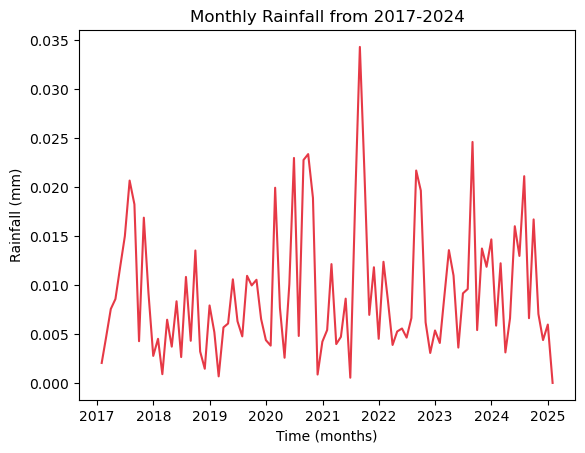

In [309]:
import pandas as pd

df = df[["Date Time", "rain (mm)"]]
df["datetime"] = pd.to_datetime(df["Date Time"])
df.set_index("datetime", inplace=True)
df = df["rain (mm)"].resample("ME").mean().to_frame(name="Rainfall")
plt.plot(df, color="#E63946")
plt.xlabel("Time (months)")
plt.ylabel("Rainfall (mm)")
plt.title("Monthly Rainfall from 2017-2024")
plt.show()

## Fitting Time Series Models

We will now create training and testing sets with the cutoff beginning at the first of the final 12 months. This will allow us to create a comparative visualization of different predictive models and diffrentiate their accuracy relative to the true data.

In [310]:
split_date = df.index[-12]

df_train = df.loc[:split_date]
df_test = df.loc[split_date:]

X_train, y_train = df_train.drop(columns=["Rainfall"]), df_train["Rainfall"]
X_test, y_test = df_test.drop(columns=["Rainfall"]), df_test["Rainfall"]

forecast_start = y_test.index[0]
forecast_end = y_test.index[-1]

The training-testing split is visualized below. 

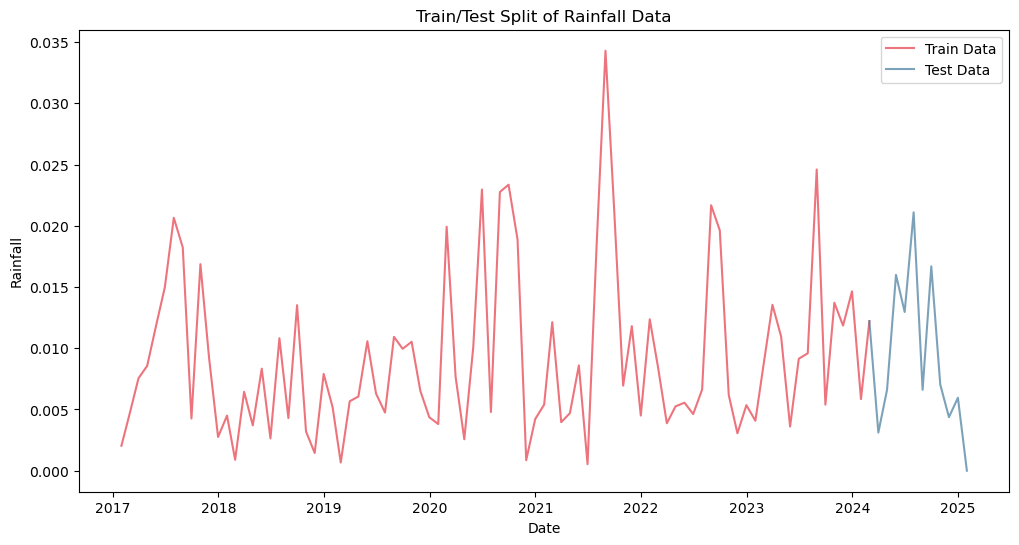

In [311]:
train_index = y_train.index
test_index = y_test.index

plt.figure(figsize=(12, 6))
plt.plot(train_index, y_train, label="Train Data", color="#E63946", alpha=0.7)
plt.plot(test_index, y_test, label="Test Data", color="#457B9D", alpha=0.7)
plt.xlabel("Date")
plt.ylabel("Rainfall")
plt.title("Train/Test Split of Rainfall Data")
plt.legend()
plt.show()

## Method 1: Random Forest Method

For the first method, we recreate the results of Tyralis and Papacharalampous. The code below features two functions: *create_lagged_features()* and *rf_predictor()*. The first of the two creates lagged vectors for the Random Forest model to regress on to. For example, since our training data has 97 observations, the data frame includes the original rainfall measurements with an additional 97 columns with data lagged at $h=1,h=2,\cdots,h=97$. Finally, the function outputs the new data frame.

The second of the two functions performs the predictions using Random Forest. After running the *create_lagged_features()* function, *rf_predictor()* fits many different Random Forests with a specific proportion of the lagged columns. These proportions range from 0.05 to 0.5, with 0.05 increments. Tyralis and Papacharalampous suggest using 500 trees for the Random Forest models as a medium between Kuhn and Johnson $_{[4]}$, and Probst and Boulesteix $_{[5]}$, who suggest 1000 and 100 trees, respectively. Within each proportional fitting, the function identifies predictors with importance. We have selected the cutoff to have *any* importance (i.e. above 0). A new Random Forest is then fit with only important predictors. After all Random Forests are fitted, the function outputs a numpy array with the predictions from every iteration. One can easily extract the predictions from each iteration by slicing the array at increments of 12 (our forecast period).

In [312]:
def create_lagged_features(lags):
    for lag in range(1, lags + 1):
        df[f"lag_{lag}"] = df["Rainfall"].shift(lag)
    return df

def rf_predictor(df):
    n1 = len(df)
    nfit = n1 - 1  
    
    test_df = create_lagged_features(nfit)
    rf = RandomForestRegressor(n_estimators=500, random_state=1)
    
    predictions = []
    
    for proportion in [0.05, 0.10, 0.15, 0.20, 0.25, 0.30, 0.35, 0.40, 0.45, 0.50]:
        num_lags = int(proportion * nfit)
        train_df = create_lagged_features(num_lags)
        
        X_train = train_df.drop(columns=["Rainfall"])
        y_train = train_df["Rainfall"]
        
        rf.fit(X_train, y_train)
        
        X_test = test_df.drop(columns=["Rainfall"])
        
        result = permutation_importance(rf, X_train, y_train, n_repeats=10, random_state=1)
        importance = result.importances_mean
        important_lags = np.where(importance > 0)[0]
        
        important_train_df = X_train.iloc[:, important_lags]
        rf.fit(important_train_df, y_train)
        
        X_test_imp = X_test.iloc[:, important_lags]
        pred_imp = rf.predict(X_test_imp)
        predictions.append(pred_imp)
    
    predictions = np.concatenate(predictions)
    return predictions

rf_pred = rf_predictor(df)

## Method 2: Box-Jenkins

For the second method, we fit several ARIMA and SARIMA models using the Box-Jenkins methodology. Furthermore, in examining the ACF and PACF plots to identify model components at the discretion of the viewer, fitting several candidate models, and harnessing AIC to source the best model, Box-Jenkins will remain the most manual approach to weather forecasting in this entire study. As a caveat to the demonstrated structural differences between R and Python, we will be using the ACF and PACF to judge stationarity from a glance before using our judgement to fit models, which inherently produces model diagnostics in table format post-fitting procedures. 

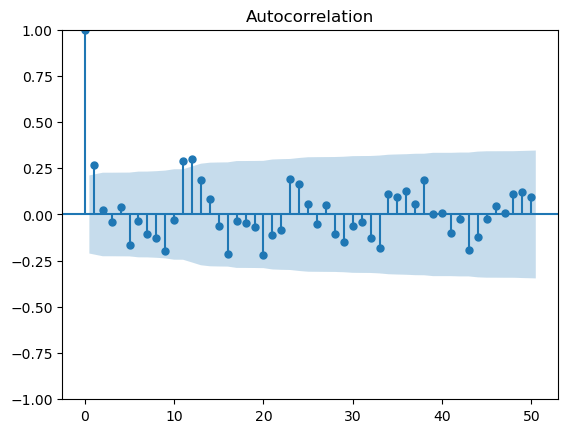

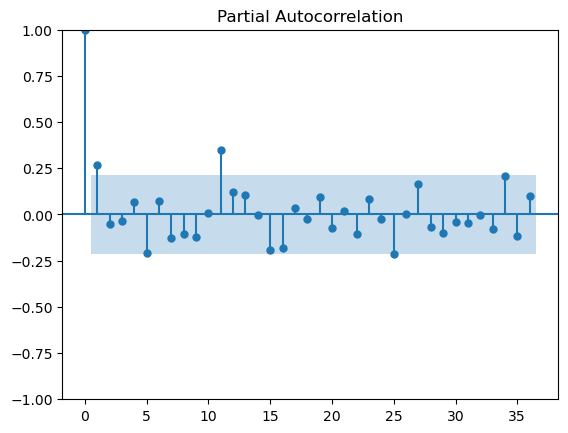

In [313]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from statsmodels.tsa.arima.model import ARIMA
from statsmodels.tsa.statespace.sarimax import SARIMAX
from statsmodels.tsa.stattools import acf,pacf
from statsmodels.graphics.tsaplots import plot_acf,plot_pacf

acf_vals = plot_acf(y_train, lags=50)
pacf_vals = plot_pacf(y_train, lags=36)

### ACF and PACF Analysis

In an effort to provide equal evaluation of the entire dataset, the aformentioned PACF and ACF plots cover the farthest possible range of previous lags in order to evaluate their statistical influence on the latest rainfall metric of the training set. In the assessment of stationarity, our extension of the lag bounds allow us to verify the stationarity and potential seasonality of our data's periodicity. Within this regard, we acknowledge the stationarity of our data with the evident majority of our data residing within the mildly-transparent confidence interval of stationary justification. Thus, our analyses have yielded the following considerations in our ARIMA model-fitting procedures:

- ACF-deduced Autoregressive (AR): 1 or 0
- Differencing (I): 0
- PACF-deduced Moving Average (MA): 1 or 0


However, within these bounds, there appear to be seasonal fluctuations with rainfall influence. Directly attributing this to known weather patterns of rainfall between Spring, Summer, Fall, and Winter of the 7 year examination, we will be incorporating a seasonal autoregressive integrated moving average (SARIMA) model in addition to our standard ARIMA models to account for potential underlying model violations in heteroskedasticity/trend stationarity.

In [314]:
# ARIMA Fitting: 
bj_ma_model = ARIMA(y_train, order=(0, 0, 1))
bj_ar_model = ARIMA(y_train, order=(1, 0, 0))
bj_arma_model = ARIMA(y_train, order=(1, 0, 1))

print(bj_ma_model.fit().summary())
print(bj_ar_model.fit().summary())
print(bj_arma_model.fit().summary())


# SARIMA Fitting:
sbj_ma_model = ARIMA(y_train, order=(0,0,1), seasonal_order=(1,0,1,12)) # best model
sbj_ar_model = ARIMA(y_train, order=(1,0,0), seasonal_order=(1,0,1,12))
sbj_arma_model = ARIMA(y_train, order=(1,0,1), seasonal_order=(1,0,1,12))

print(sbj_ma_model.fit().summary())
print(sbj_ar_model.fit().summary())
print(sbj_arma_model.fit().summary())

# For future predictions
bj_pred = sbj_ma_model.fit().predict(start=forecast_start,end=forecast_end)

                               SARIMAX Results                                
Dep. Variable:               Rainfall   No. Observations:                   86
Model:                 ARIMA(0, 0, 1)   Log Likelihood                 312.457
Date:                Wed, 19 Mar 2025   AIC                           -618.915
Time:                        21:25:57   BIC                           -611.552
Sample:                    01-31-2017   HQIC                          -615.951
                         - 02-29-2024                                         
Covariance Type:                  opg                                         
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
const          0.0092      0.001      8.343      0.000       0.007       0.011
ma.L1          0.2755      0.082      3.367      0.001       0.115       0.436
sigma2      4.086e-05   6.78e-06      6.028      0.0

/opt/anaconda3/lib/python3.12/site-packages/statsmodels/base/model.py:607: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "
/opt/anaconda3/lib/python3.12/site-packages/statsmodels/base/model.py:607: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "


                                     SARIMAX Results                                      
Dep. Variable:                           Rainfall   No. Observations:                   86
Model:             ARIMA(1, 0, 0)x(1, 0, [1], 12)   Log Likelihood                 315.570
Date:                            Wed, 19 Mar 2025   AIC                           -621.139
Time:                                    21:25:58   BIC                           -608.867
Sample:                                01-31-2017   HQIC                          -616.200
                                     - 02-29-2024                                         
Covariance Type:                              opg                                         
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
const          0.0093      0.001      6.928      0.000       0.007       0.012
ar.L1          0.1610      0.106   

/opt/anaconda3/lib/python3.12/site-packages/statsmodels/base/model.py:607: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "


As expected, our results' accuracy vary heavily with gaps of differing significance in each model. Within our examination of the simpler ARIMA models, a lack of statistical significance from our Jarque-Bera Statistics and Ljung-Box Q-Statistics reveal unreliability in the trends captured. However, as we examine the statistical significance of more complex models accounting for seasonality across periods of 12 months, we grasp trend statistics with greater reliability in forecasting capacity. Specifically, while the SARIMA(1,0,1)x(1,0,1,12) model lacks statistical significance across multiple underlying assumptions, SARIMA(1,0,0)x(1,0,1,12) and SARIMA(0,0,1)x(1,0,1,12) retain statistically significant deductions, with a slightly greater edge in accuracy in the latter model observed from AIC. Albeit, a manually-conceived estimation, we will be using the SARIMA(0,0,1)x(1,0,1,12) as our ideal candidate, proceeding to use its "N-Steps Ahead" Prediction as a comparative metric later in our study.

## Method 3: Auto Arima Fitting

As our third and final method, we fit an Auto ARIMA model. While, Auto ARIMA is widely regarded as highly inconsistent and unpredictable in its autonomous coefficient-selection process, its convenience in comparing a wide range of models allows us to find a reasonable-fitting model within a fraction of the time dedicated to manually-estimating in Box-Jenkins. Our parameter selection reasoning can be confined to the following:

- seasonal = True: confirming the presence of seasonality in our data
- trace = False: hiding pre-model processing for the sake of readability
- suppress_warnings = True: hiding warnings for greater readability
- stepwise=True: As it can be very computationally expensive in fully-evaluating every potential permutational (p,d,q)x(P,D,Q) sequence, we apply a stepwise search algorithm, reducing the search time with compromised "greediness" in a smaller possible statespace of evaluated models.
- information_criterion = 'aic': a selection indicating our benchmarking with the Aikage Information Criterion (AIC) metric for comparison
- random_state = 1: setting a seed across our simulation to create consistently comparable results for reproducability

In [315]:
# AUTO ARIMA Coding Module
from pmdarima import auto_arima

## Model-Fitting Procedures
monthly_model = auto_arima(
    y_train,
    seasonal = True,
    trace = False,
    suppress_warnings = True,
    stepwise = True,
    stationary = True,
    information_criterion = 'aic', 
    random_state = 1
    )

print("Test 1: Monthly Model Summary")
print(monthly_model.summary())
print("\n")

## Forecasting 
auto_arima_pred = monthly_model.predict(n_periods=len(y_test))


Test 1: Monthly Model Summary
                               SARIMAX Results                                
Dep. Variable:                      y   No. Observations:                   86
Model:               SARIMAX(1, 0, 0)   Log Likelihood                 312.493
Date:                Wed, 19 Mar 2025   AIC                           -618.986
Time:                        21:25:58   BIC                           -611.623
Sample:                    01-31-2017   HQIC                          -616.022
                         - 02-29-2024                                         
Covariance Type:                  opg                                         
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
intercept      0.0068      0.001      4.803      0.000       0.004       0.010
ar.L1          0.2685      0.099      2.724      0.006       0.075       0.462
sigma2      4.082e-05 

# Model Comparison

We will be comparing the performance of the three models through visuals and mathematical methods. Note that there were 10 different proportions of lagged predictors from which random forests were fit, so the top 3 performers (based on test MSE) are included. These values are calculated below.

In [316]:
predictions_dict = {}

chunk_size = 12
increment = 0
proportions = [5, 10, 15, 20, 25, 30, 35, 40, 45, 50]
for i in range(10):
    predictions_dict[f"{proportions[i]}%"] = mean_squared_error(rf_pred[i+chunk_size*increment:i + chunk_size+chunk_size*increment], y_test)
    increment += 1
predictions_df = pd.DataFrame.from_dict(predictions_dict, orient = "index",
                                        columns = ["Mean Squared Error"])
print(predictions_df)

     Mean Squared Error
5%             0.000034
10%            0.000035
15%            0.000050
20%            0.000050
25%            0.000048
30%            0.000057
35%            0.000052
40%            0.000073
45%            0.000059
50%            0.000056


We can see that in ascending descending order, the trees which used 5%, 10%, and 25% of predictors had the best performance, respectively. These results validate the results of Tyralis and Papacharalampous that trees with lower performance exhibit the best performance. The predictions of all models is found below.

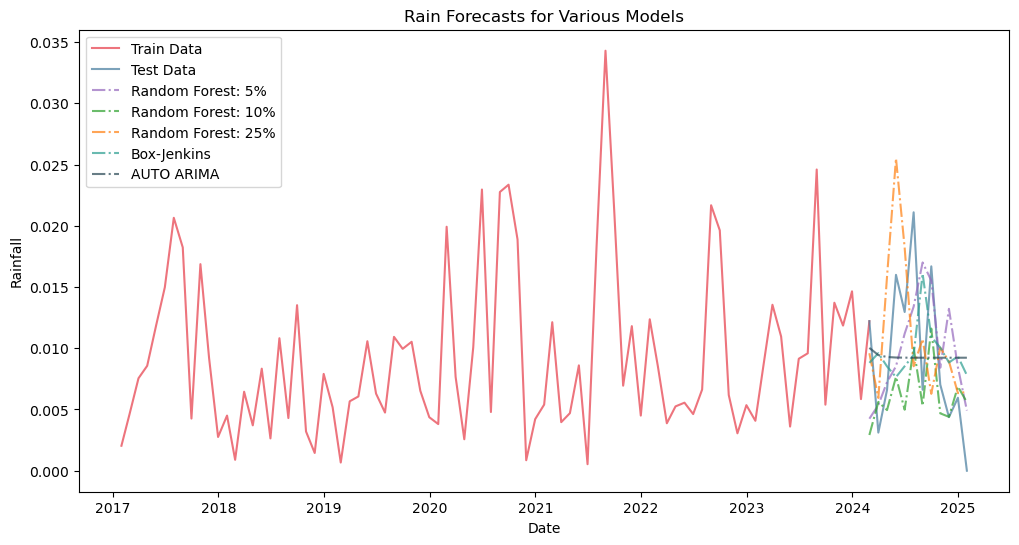

In [317]:
# Comparable Visualization 
plt.figure(figsize=(12, 6))
plt.plot(train_index, y_train, label="Train Data", color="#E63946", alpha=0.7)
plt.plot(test_index, y_test, label="Test Data", color="#457B9D", alpha=0.7)
plt.plot(test_index, rf_pred[:12], label="Random Forest: 5%", color="#9467bd", alpha=0.7,ls="-.")
plt.plot(test_index, rf_pred[13:25], label="Random Forest: 10%", color="#2ca02c", alpha=0.7,ls="-.")
plt.plot(test_index, rf_pred[52:64], label="Random Forest: 25%", color="#ff7f0e", alpha=0.7,ls="-.")
plt.plot(test_index, bj_pred, label="Box-Jenkins", color="#2A9D8F", alpha=0.7,ls="-.")
plt.plot(test_index, auto_arima_pred, label="AUTO ARIMA", color="#264653", alpha=0.7,ls="-.")
plt.xlabel("Date")
plt.ylabel("Rainfall")
plt.title("Rain Forecasts for Various Models")
plt.legend()
plt.show()

In [318]:
rf_five_prop_mse = mean_squared_error(rf_pred[:12], y_test)
rf_ten_prop_mse = mean_squared_error(rf_pred[13:25], y_test)
rf_twentyfive_prop_mse = mean_squared_error(rf_pred[52:64], y_test)

box_jenkins_mse = mean_squared_error(bj_pred, y_test)
auto_arima_mse = mean_squared_error(auto_arima_pred, y_test)

mse = [["Random Forest: 5%", rf_five_prop_mse], 
       ["Random Forest: 10%", rf_ten_prop_mse],
       ["Auto Arima",auto_arima_mse],
       ["Random Forest: 25%", rf_twentyfive_prop_mse],
       ["Box-Jenkins", box_jenkins_mse]]
df = pd.DataFrame(mse, columns=["Method", "Mean Squared Error"])
print(df)

               Method  Mean Squared Error
0   Random Forest: 5%            0.000034
1  Random Forest: 10%            0.000035
2          Auto Arima            0.000037
3  Random Forest: 25%            0.000048
4         Box-Jenkins            0.000042


From the above table, we find that two of the three Random Forest models outperform the other methods in terms of test MSE. In particular, the Random Forest model utilizing 5% of the lagged predictors had a significantly lower error.

# Conclusion

In this project, we validated the results of Tyralis and Papacharalampous that time series forecasts can be efficiently performed utilizing Random Forests train on small proportions of lagged data. Further, we compared the prediction accuracy of the Random Forests with other contemporary methods such as Box-Jenkins and Auto ARIMA. In comparing test MSE, we found that the Random Forest models outperformed the other methods. 

Of course, our results are not without fault. In the function utilized to fit the Random Forest models, we set the variable importance cutoff to be zero. In doing this, we allowed predictors that may have had minute impact to be included in the final model, which may have contributed to overfitting. Future research may improve upon this by introducing the cutoff as a validation parameter. Further, while we were able to cross validate by fitting several random forest models, more folds with larger data sets may provide more detailed insights. 

Overall, these results offer an exciting new perspective to time series modeling, as while something like the Box-Jenkins methodology has stood the test of time, new methods are created everyday that present new ways of making accurate forecasts.

# References

1. Engle, R. F. (1982). Autoregressive conditional heteroscedasticity with estimates of the variance of United Kingdom inflation. Econometrica, 50(4), 987–1007. The Econometric Society. https://doi.org/10.2307/1912773.

2. Tyralis, H., & Papacharalampous, G. (2017). Variable Selection in Time Series Forecasting Using Random Forests. Algorithms, 10(4), 114. https://doi.org/10.3390/a10040114

3. Jansen, M. (2024). BGC Jena weather station dataset (2017–2024) [Dataset]. Kaggle. https://www.kaggle.com/datasets/matthewjansen/bgc-jena-weather-station-dataset-20172024.

4. Kuhn, M.; Johnson, K. Applied Predictive Modeling; Springer: New York, NY, USA, 2013. [Google Scholar]

5. Probst, P.; Boulesteix, A.L. To tune or not to tune the number of trees in random forest? arXiv 2017, arXiv:1705.05654v1. [Google Scholar]